In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, exp, cos, log, trigsimp, nsimplify, pi, lambdify, diff, solve, N
from scipy.optimize import minimize
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution
from joblib import Parallel, delayed
from tqdm import tqdm

#h, k, beta, gamma = symbols(("h","\kappa",r"\beta", "\gamma"))

#N = 8

#d = 4
pi = np.pi

N = 6

d = 4

def c(h,k):
    c_val = 0
    for n in range(N):
        c_val += np.exp((h*np.cos(2*pi*n/N) + k*np.cos(4*pi*n/N)))

    return c_val

def t(h,k):
    t_val = 0
    for n in range(N):
        t_val += np.cos(2*pi*n/N)*np.exp((h*np.cos(2*pi*n/N) + k*np.cos(4*pi*n/N)))

    return t_val/c(h,k)

def u(h,k):
    u_val = 0
    for n in range(N):
        u_val += np.cos(4*pi*n/N)*np.exp((h*np.cos(2*pi*n/N) + k*np.cos(4*pi*n/N)))

    return u_val/c(h,k)

# def c(h,k):
#     c_val = 0
#     for n in range(N):
#         c_val += np.exp((h*np.exp(1j*2*pi*n/N) + k*np.exp(1j*4*pi*n/N))+np.conj((h*np.exp(1j*2*pi*n/N) + k*np.exp(1j*4*pi*n/N))))

#     return c_val

# def t(h,k):
#     t_val = 0
#     for n in range(N):
#         t_val += (np.exp(1j*2*pi*n/N)+np.exp(-1j*2*pi*n/N))*np.exp((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N)) + np.conj((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N))))

#     return t_val/c(h,k)

# def u(h,k):
#     u_val = 0
#     for n in range(N):
#         u_val += (np.exp(1j*4*pi*n/N)+np.exp(-1j*4*pi*n/N))**np.exp((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N)) + np.conj((h*np.exp(1j*2*pi*n/N) + k*np.cos(1j*4*pi*n/N))))

#     return u_val/c(h,k)

def F_func(h,k,beta,gamma):
    return (-d*np.log(c(h,k)) + d*t(h,k)*(h - (1/2)*(d-1)*beta*t(h,k)**3) + d*u(h,k)*(k - (1/2)*(d-1)*gamma*u(h,k)**3))
# def F_func(h,k,beta,gamma):
#    return -np.log(c(h,k)) + k*u(h,k) + h*t(h,k) - 0.5*(d-1)*gamma*(u(h,k)**4) - 0.5*(d-1)*beta*(t(h,k)**4)

# Lambdify to create a NumPy-compatible function
#f_func = lambdify((x, y), f_sym, modules='numpy')






#F_func = lambdify((h, k, beta, gamma), F, modules='numpy')

def calc(beta_val):
    #beta_val = 1.2
    def critical(gamma_val):
        # 3. Fix z and t

        
        #gamma_val = 1.2

        def mu(h,k):
            #return (1+u(h,k) - 2*t(h,k)**2)
            return (1 - 2*u(h,k) + t(h,k)**2)
            #return  u(h,k) - t(h,k)**2

        # Define function for minimizer
        def f_to_minimize(vars):
            return F_func(*vars,beta_val,gamma_val)

        # Initial guess
        initial_guess = [1, 1]
        bounds = [(0, None),  # x ≥ 0
                (0, None)]  

        result = differential_evolution(
            f_to_minimize,
            bounds=[(0, 25), (0, 25)],
            strategy='best1bin',
            maxiter=10000,
            popsize=254*2,
            tol=2e-17,
            polish=True,   # optional local refinement (uses L-BFGS-B)
        )

        # Output result
        #print("Minimum at:", result.x)
        #print("Function value:", (mu(*result.x)))
        return (mu(*result.x))


    Num_points = 150
    
    gammas = np.linspace(-1.4,2.0,Num_points)
    mus = np.zeros(Num_points)

    for i,j in enumerate(gammas):
        mus[i] = (critical(j))


    return mus
    #plt.scatter(gammas, mus)

beta_list = np.linspace(-1.4, 4, int(14*10))
mus_list = []

gammas_list = np.linspace(-1.1,2.0,150)

#for i in tqdm(beta_list):
#    mus_list.append(calc(i))
    
    
mus_list = Parallel(n_jobs=14)(
    delayed(calc)(beta) for beta in tqdm(beta_list)
)
    


100%|██████████| 30/30 [06:41<00:00, 13.40s/it]


In [35]:
gammas_list = np.linspace(-1.1,1.1,100)

In [103]:
np.save('ord_param_z6_fine_data.npy', mus_list)

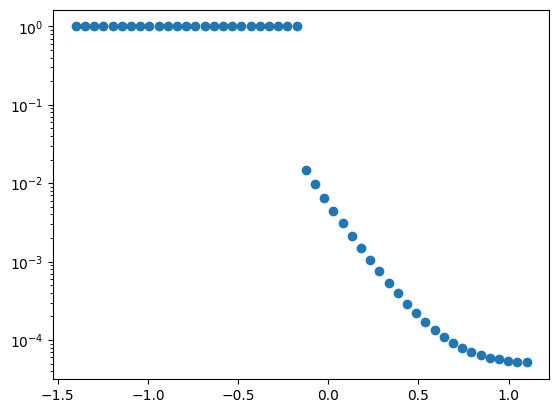

In [139]:
test = np.array(mus_list).reshape(-1)

plt.scatter(gammas_list, mus_list[0])
plt.yscale('log')

In [140]:

def outliers(data, threshold=1000):

    data = np.asarray(data, dtype=float)
    cleaned = data.copy()
    mask = np.zeros_like(data, dtype=bool)

    for i in range(1, len(data) - 1):
        local_mean = (data[i - 1] + data[i + 1]) / 2
        local_dev = abs(data[i] - local_mean)
        neighbor_std = np.std([data[i - 1], data[i + 1]])

        # If deviation is more than threshold × neighbor std → outlier
        if neighbor_std > 0 and local_dev > threshold * neighbor_std:
            cleaned[i] = local_mean  # Replace with average of neighbors
            mask[i] = True

    return cleaned, mask

def crit_values(o_param, gammas):
    d_o_param = np.abs(np.gradient(o_param, gammas))
    dd_o_param = np.abs(np.gradient(d_o_param, gammas))
    
    o_param_diff = []
    
    for i in range(len(o_param)-1):
        o_param_diff.append(abs(o_param[i]-o_param[i+1]))
    index = np.where(o_param_diff == np.max(o_param_diff))[0][0]
    d_index = np.where(d_o_param == np.max(d_o_param[index+2:]))[0][0]
    #index2 = 0
    if dd_o_param[d_index] < 1e-1:
        return index, d_index
        #dd_index = np.where(dd_o_param == np.max(dd_o_param[index+2:]))[0]
    else:
        return index
    
def find_crits(mus_val, gammas):
    indices = []
    for mu in mus_val:
        indices.append(crit_values(outliers(mu)[0], gammas))
    
    return indices
    
index_list = find_crits(mus_list, gammas_list)
#mu_filt, mask = outliers(mus)
#print(mus[mask])

#plt.scatter(gammas, mu_filt, marker='x')


In [141]:
def map_indices(idx_list, values):
    result = []
    for entry in idx_list:
        if isinstance(entry, tuple):
            # Map each element of the tuple
            result.append([values[i] for i in entry])
        else:
            # Single integer index
            result.append(values[entry])
    return result

gammas_crit = map_indices(index_list, gammas_list)

In [65]:
gammas_crit

[]

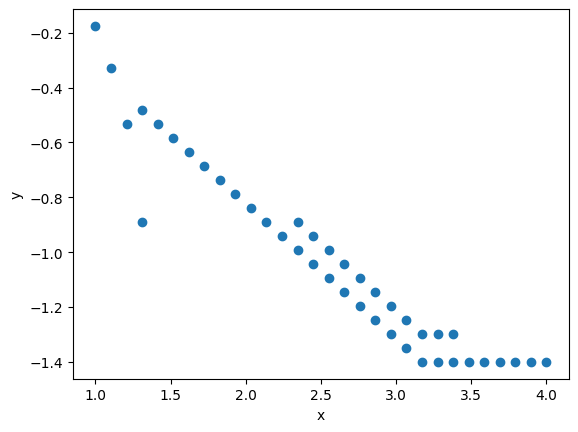

In [142]:
import matplotlib.pyplot as plt

xs = []
ys = []
for xi, yi in zip(beta_list, gammas_crit):
    if isinstance(yi, (list, tuple)):
        for v in yi:
            xs.append(xi)
            ys.append(v)
    else:
        xs.append(xi)
        ys.append(yi)
    

plt.figure()
plt.scatter(xs, np.array(ys))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [108]:
mus_np = np.array(ys)

print(mus_np)
offset = 5
idx = np.abs(mus_np[offset:]).argmin()

print(xs[idx + offset])

[ 0.13389831  0.03728814 -0.12372881 -0.41355932 -0.1559322  -0.18813559
 -0.22033898 -0.28474576 -0.31694915 -0.34915254 -0.38135593 -0.41355932
 -0.4779661  -0.51016949 -0.54237288 -0.57457627 -0.60677966 -0.63898305
 -0.70338983 -0.73559322 -0.76779661 -0.8        -0.8        -0.8
 -0.8        -0.8        -0.8        -0.8        -0.8        -0.8       ]
1.5172413793103448


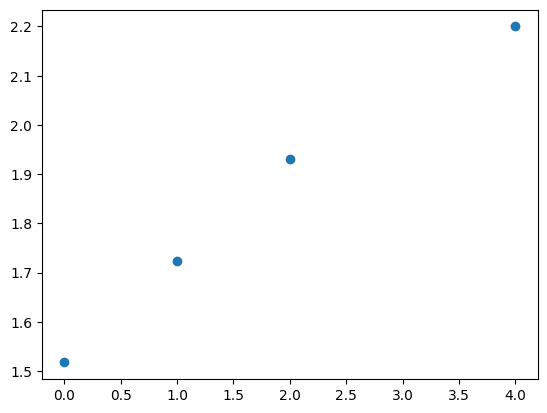

In [100]:
beta_c2 = [1.5172413793103448,1.7241379310344827, 1.9310344827586206, np.nan, 2.1999999999999997]
Ns = [0,1,2,3,4]

plt.scatter(Ns, beta_c2)

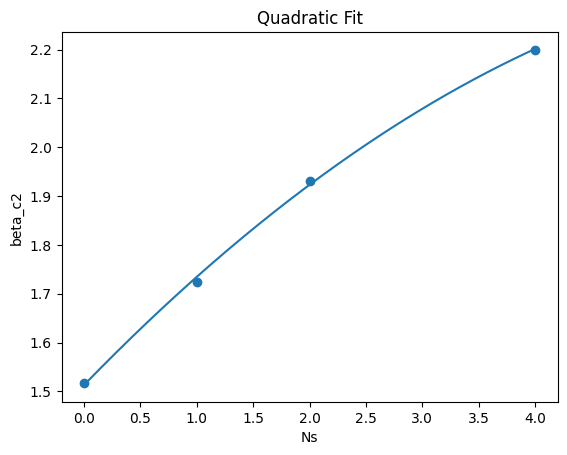

[-0.01645768  0.23783699  1.51329154]


In [110]:
import numpy as np
import matplotlib.pyplot as plt

beta_c2 = np.array([1.5172413793103448, 1.7241379310344827, 1.9310344827586206, np.nan, 2.1999999999999997])
Ns = np.array([0, 1, 2, 3, 4])

mask = ~np.isnan(beta_c2)
Ns_fit = Ns[mask]
beta_fit = beta_c2[mask]

coeffs = np.polyfit(Ns_fit, beta_fit, 2)
poly = np.poly1d(coeffs)

x = np.linspace(Ns_fit.min(), Ns_fit.max(), 200)
y = poly(x)

plt.figure()
plt.scatter(Ns_fit, beta_fit)
plt.plot(x, y)
plt.xlabel("Ns")
plt.ylabel("beta_c2")
plt.title("Quadratic Fit")
plt.show()

print(coeffs)


In [25]:
index_list

[72,
 72,
 72,
 72,
 72,
 68,
 65,
 60,
 56,
 51,
 46,
 (38, 44),
 (22, 42),
 40,
 39,
 38,
 (36, 38),
 (35, 37),
 (34, 36),
 (32, 34)]

-0.04177215189873418 0.12531645569620253


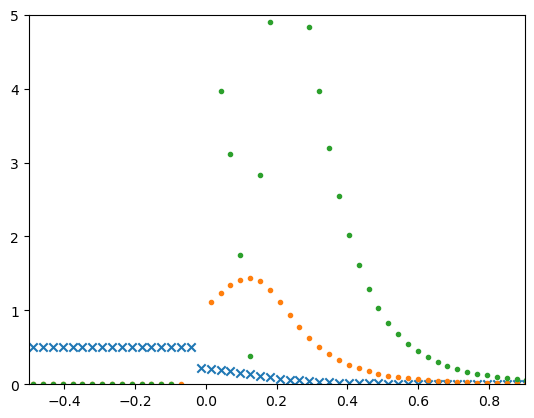

In [9]:
d_mus = np.abs(np.gradient(mu_filt, gammas))
dd_mus = np.abs(np.gradient(d_mus, gammas))
plt.scatter(gammas, mu_filt/2, marker='x')
plt.scatter(gammas, d_mus, marker='.')
plt.scatter(gammas, dd_mus, marker='.')
plt.xlim(-0.5, 0.9)
plt.ylim(0,5)

def crit_values(o_param, d_o_param, dd_o_param):
    o_param_diff = []
    
    for i in range(len(o_param)-1):
        o_param_diff.append(abs(o_param[i]-o_param[i+1]))
    index = np.where(o_param_diff == np.max(o_param_diff))[0][0]
    d_index = np.where(d_o_param == np.max(d_o_param[index+2:]))[0][0]
    #index2 = 0
    if dd_o_param[d_index] < 5e-1:
        return index, d_index
        #dd_index = np.where(dd_o_param == np.max(dd_o_param[index+2:]))[0]
    else:
        return index

c1, c2 = crit_values(mus, d_mus, dd_mus)



print(gammas[c1],gammas[c2])

In [76]:
threshold = 0.6
mask = (mus < threshold) & (mus > 0.05)

x = gammas
y = mus

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


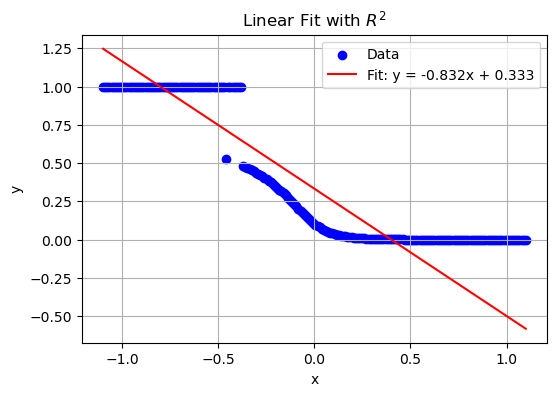

In [81]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def linear_reg(x,y):
    result = stats.linregress(x, y)
    slope = result.slope
    intercept = result.intercept
    r_value = result.rvalue  # correlation coefficient
    r_squared = r_value ** 2
    
    return slope, intercept, r_squared
    

def select_linear(x,y, tol = 0.001):
    i = 1
    r2 = 0

    for _ in range(int(len(x)/2)):
        r2_new = linear_reg(x[i:-i],y[i:-i])[2]
        if r2_new > r2 - tol:
            r2 = r2_new
            i += 1
            print(i)
        else:
            break
        
    return linear_reg(x[i:-i],y[i:-i])

#x = np.array([0, 1, 2, 3, 4, 5])
#y = np.array([2.1, 2.9, 4.2, 5.1, 6.9, 7.8])




slope, intercept = select_linear(x,y)[:2]

y_fit = slope * x + intercept

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(x, y_fit, label=f'Fit: y = {slope:.3f}x + {intercept:.3f}', color='red')
plt.xlabel('x')
plt.ylabel('y')
#plt.xlim(-0.2,0.2)
plt.title('Linear Fit with $R^2$')
plt.legend()
plt.grid(True)
plt.show()
  

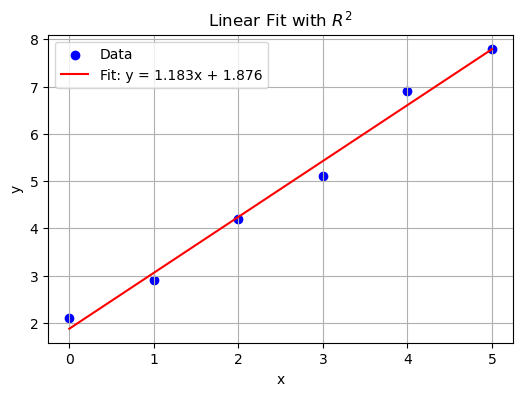

Slope:      1.18286
Intercept:  1.87619
R-squared:  0.98917


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Example data
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([2.1, 2.9, 4.2, 5.1, 6.9, 7.8])

# --- Perform linear regression using scipy ---
result = stats.linregress(x, y)

# Extract fit parameters
slope = result.slope
intercept = result.intercept
r_value = result.rvalue  # correlation coefficient
r_squared = r_value ** 2

# Predicted line
y_fit = slope * x + intercept

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(x, y_fit, label=f'Fit: y = {slope:.3f}x + {intercept:.3f}', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Fit with $R^2$')
plt.legend()
plt.grid(True)
plt.show()

# --- Print results ---
print(f"Slope:      {slope:.5f}")
print(f"Intercept:  {intercept:.5f}")
print(f"R-squared:  {r_squared:.5f}")